In [35]:
import pandas as pd
import seaborn as sns
import pybedtools as pbt
import sys
import matplotlib.pyplot as plt
import numpy as np
import itertools

## Prepare list of genes, adding promoters
To link SNPs, peaks, and loops to genes, we first need a list of genes and their coordinates. I'll download this from GENCODE as a GTF, then extract the necessary info and convert the coordinates to BED for use in intersection with pyBedTools

In [37]:
# Change the working directory to the data dir
%cd ../data/snp_data

[Errno 2] No such file or directory: '../data/snp_data'
/gpfs/fs1/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data


In [38]:
%pwd

'/gpfs/fs1/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data'

In [4]:
# # Download genome annotation and extract whole-gene records
# ! mkdir -p resources
# ! curl ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_33/gencode.v33.annotation.gtf.gz | \
#     gunzip -c | awk '{OFS="\t"}{if ($3 == "gene"){print $0}}' > resources/gencode.v33.annotation.gtf

In [4]:
a = pbt.BedTool("resources/gencode.v33.annotation.gtf").to_dataframe()
a.head()

,seqname,source,feature,start,end,score,strand,frame,attributes
0,chr1,HAVANA,gene,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5""; gene_type ""transc..."
1,chr1,HAVANA,gene,14404,29570,.,-,.,"gene_id ""ENSG00000227232.5""; gene_type ""unproc..."
2,chr1,ENSEMBL,gene,17369,17436,.,-,.,"gene_id ""ENSG00000278267.1""; gene_type ""miRNA""..."
3,chr1,HAVANA,gene,29554,31109,.,+,.,"gene_id ""ENSG00000243485.5""; gene_type ""lncRNA..."
4,chr1,ENSEMBL,gene,30366,30503,.,+,.,"gene_id ""ENSG00000284332.1""; gene_type ""miRNA""..."


In [5]:
attributes = a.attributes.str.split(';', expand=True).iloc[:,:3].apply(lambda x: x.str.split('"', expand=True)[1], axis=1)

In [6]:
attributes.columns = ['name_gene', 'gene_type', 'gene_symbol']
a = pd.concat([a.drop(columns='attributes'),attributes], axis=1)

In [7]:
# a['start'] = a['start'] - 1 # Drop to 0-based index before converting to BED
# pbt.BedTool().from_dataframe(a[['seqname', 'start', 'end', 'name_gene', 'score','strand']]).saveas('resources/gencodev33_ensembl_genes.bed')

Make a table to later convert ENSID to gene symbol

In [8]:
conversion = a[['name_gene', 'gene_symbol', 'gene_type']]
conversion.head()

,name_gene,gene_symbol,gene_type
0,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene
1,ENSG00000227232.5,WASH7P,unprocessed_pseudogene
2,ENSG00000278267.1,MIR6859-1,miRNA
3,ENSG00000243485.5,MIR1302-2HG,lncRNA
4,ENSG00000284332.1,MIR1302-2,miRNA


In [9]:
genes_bed = pbt.BedTool("resources/gencodev33_ensembl_genes.bed").to_dataframe()

In [10]:
genes_bed.head()

,chrom,start,end,name,score,strand
0,chr1,11867,14409,ENSG00000223972.5,.,+
1,chr1,14402,29570,ENSG00000227232.5,.,-
2,chr1,17367,17436,ENSG00000278267.1,.,-
3,chr1,29552,31109,ENSG00000243485.5,.,+
4,chr1,30364,30503,ENSG00000284332.1,.,+


In [11]:
def addPromoter(x, length=1000):
    if x['strand'] == '+' and x['start'] > length:
        x['start'] -= length
    elif x['strand'] == '+' and x['start'] <= length:
        x['start'] = 0
    else:
        x['end'] += length
    return x

In [12]:
def extractPromoters(x, length=1000):
    if x['strand'] == '+' and x['start'] > length:
        x['end'] = x['start']
        x['start'] -= length
    elif x['strand'] == '+' and x['start'] <= length:
        x['end'] = x['start']
        x['start'] = 0
    else:
        x['start'] = x['end']
        x['end'] += length
    return x

In [13]:
genes_wpromoter = genes_bed.apply(addPromoter, axis=1)

In [14]:
genes_promoters = pbt.BedTool().from_dataframe(genes_wpromoter)

In [15]:
all_promoters = genes_bed.apply(extractPromoters, axis=1)

In [16]:
all_promoters = pbt.BedTool().from_dataframe(all_promoters)

In [17]:
genes_promoters.head()

chr1	10867	14409	ENSG00000223972.5	.	+
 chr1	14402	30570	ENSG00000227232.5	.	-
 chr1	17367	18436	ENSG00000278267.1	.	-
 chr1	28552	31109	ENSG00000243485.5	.	+
 chr1	29364	30503	ENSG00000284332.1	.	+
 chr1	34552	37081	ENSG00000237613.2	.	-
 chr1	51471	53312	ENSG00000268020.3	.	+
 chr1	56596	64116	ENSG00000240361.2	.	+
 chr1	64417	71585	ENSG00000186092.6	.	+
 chr1	89293	134723	ENSG00000238009.6	.	-
 

## How many Th1/17 ATAC peaks contain a GWAS SNP?

In [19]:
# %%bash
# # Convert merged ATAC SAF file to BED
# awk 'OFS="\t" {{print $2,$3-1,$4,$1,$5}}' ../atac-seq/200102_human_th1_th17_atac/peaks/combined_peaks_merged.saf > atac_snp_loop/combined_ATAC_peaks.bed

In [21]:
!wc -l /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/ld_expansion_psoriasis/ps_ld_snps_r2_0.8_new.bed
!wc -l /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop/combined_ATAC_peaks.bed

3840 /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/ld_expansion_psoriasis/ps_ld_snps_r2_0.8_new.bed
88138 /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop/combined_ATAC_peaks.bed


There are 3840 unique SNPs for IBD and 88138 ATACseq peaks from Th1 and Th2

In [22]:
# Load all ATAC peaks and GWAS LD-enhanced SNPs
atac = pbt.BedTool("atac_snp_loop/combined_ATAC_peaks.bed")
gwas = pbt.BedTool("ld_expansion_psoriasis/ps_ld_snps_r2_0.8_new.bed")

In [23]:
# Intersect ATAC peaks with GWAS SNPs
atac_gwas = atac.intersect(gwas, nonamecheck=True, loj=True).to_dataframe()
atac_gwas.columns = ['chrom_atac', 'start_atac', 'end_atac', 'name_atac', 'score', 
                     'chr_snp', 'start_snp', 'end_snp', 'name_snp']
atac_gwas = atac_gwas.replace([-1, "."], np.nan)

In [24]:
atac_gwas

,chrom_atac,start_atac,end_atac,name_atac,score,chr_snp,start_snp,end_snp,name_snp
0,chr1,9939,11526,chr1.9940.11526,NaN,NaN,NaN,NaN,NaN
1,chr1,28527,30143,chr1.28528.30143,NaN,NaN,NaN,NaN,NaN
2,chr1,38551,38855,chr1.38552.38855,NaN,NaN,NaN,NaN,NaN
3,chr1,91075,91593,chr1.91076.91593,NaN,NaN,NaN,NaN,NaN
4,chr1,127420,127976,chr1.127421.127976,NaN,NaN,NaN,NaN,NaN
5,chr1,136176,137561,chr1.136177.137561,NaN,NaN,NaN,NaN,NaN
6,chr1,180665,182081,chr1.180666.182081,NaN,NaN,NaN,NaN,NaN
7,chr1,191235,191987,chr1.191236.191987,NaN,NaN,NaN,NaN,NaN
8,chr1,199113,200559,chr1.199114.200559,NaN,NaN,NaN,NaN,NaN
9,chr1,205419,206795,chr1.205420.206795,NaN,NaN,NaN,NaN,NaN


In [25]:
!mkdir -p /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop_ps

In [26]:
pbt.BedTool().from_dataframe(atac_gwas).saveas("atac_snp_loop_ps/ATAC_snp_overlap.bed")

<BedTool(atac_snp_loop_ra/ATAC_snp_overlap.bed)>

In [27]:
# Find which ATAC peaks overlap promoters
atac_promoter = atac.intersect(all_promoters, nonamecheck=True).to_dataframe()

In [28]:
# How many SNPs are in each ATAC peak?
atac_gwas.groupby('name_atac').count().sort_values('name_snp', ascending=False).head()

,chrom_atac,start_atac,end_atac,score,chr_snp,start_snp,end_snp,name_snp
name_atac,,,,,,,,
chr5.96895556.96897171,10,10,10,0,10,10,10,10
chr17.75877312.75879080,7,7,7,0,7,7,7,7
chr5.96904004.96904672,5,5,5,0,5,5,5,5
chr21.33403118.33404760,5,5,5,0,5,5,5,5
chr22.21587533.21588735,4,4,4,0,4,4,4,4


In [29]:
print("%.4f%% of ATAC peaks contain a GWAS SNP" % (sum(~atac_gwas.drop_duplicates('name_atac').name_snp.isna()) / len(atac_gwas.drop_duplicates('name_atac'))))

0.0017% of ATAC peaks contain a GWAS SNP


In [30]:
atac_gwas[~atac_gwas.name_snp.isna()].drop_duplicates(["name_atac", 'name_snp']).head()

,chrom_atac,start_atac,end_atac,name_atac,score,chr_snp,start_snp,end_snp,name_snp
339,chr1,8211581,8212303,chr1.8211582.8212303,NaN,chr1,8212170.0,8212171.0,rs11121131
578,chr1,11805234,11806600,chr1.11805235.11806600,NaN,chr1,11806393.0,11806394.0,rs3737965
579,chr1,11838203,11839035,chr1.11838204.11839035,NaN,chr1,11838731.0,11838732.0,rs2272803
1098,chr1,24186929,24187831,chr1.24186930.24187831,NaN,chr1,24187122.0,24187123.0,rs78312791
1099,chr1,24186929,24187831,chr1.24186930.24187831,NaN,chr1,24187277.0,24187278.0,rs4090311


In [31]:
# How many ATAC peaks contained GWAS SNPs?
sum(~atac_gwas.drop_duplicates('name_atac').name_snp.isna())

149

Out of the ~88k peaks, only 149 peaks contain GWAS SNPs

## Find loop-mediated ATAC-gene interactions

In [32]:
# %%bash
# # Extract the loops from BEDPE to BED files with loop IDs

# # awk 'OFS="\t" {print "chr"$1,$2,$3,"th17."NR-1"_left\nchr"$4,$5,$6,"th17."NR-1"_right"}' \
# # ../190416_human_hic/th17/mega/aligned/loops_pw631/merged_loops_noheader.bedpe \
# # > all_th17_anchors.bed

# # awk 'OFS="\t" {print "chr"$1,$2,$3,"th1."NR-1"_left\nchr"$4,$5,$6,"th1."NR-1"_right"}' \
# # ../190416_human_hic/th1/mega/aligned/loops_pw631/merged_loops_noheader.bedpe \
# # > all_th1_anchors.bed

# awk 'OFS="\t" {print $1,$2,$3,"loop."NR-1"_left\n"$4,$5,$6,"loop."NR-1"_right"}' \
# "loops/merged_loops.bedpe" \
# > "atac_snp_loop/all_anchors.bed"

In [33]:
# %%bash
# # Concatenate the loops from Th1 and Th17
# cat all_th17_anchors.bed all_th1_anchors.bed > all_anchors.bed

In [19]:
# Load the loops into python
# th17_anchor = pbt.BedTool("all_th17_anchors.bed")
# th1_anchor = pbt.BedTool("all_th1_anchors.bed")
all_anchor = pbt.BedTool("atac_snp_loop/all_anchors.bed")
len(all_anchor)

32488

In [20]:
def reformatAnchorName(df):
    '''Takes the anchor name, creates a new column for left vs right ("anc_pos") and 
    moves the anchor ID to the index'''
    split_anchors = df.name_anc.str.split("_", expand=True)
    split_anchors.columns = ['name_anc', 'anc_pos']
    df = df.drop(columns='name_anc')
    df = pd.concat((df, split_anchors), axis=1)
    return df

In [23]:
# Intersect all anchors with combined ATAC peaks
anchor_atac = all_anchor.intersect(atac, loj=True, nonamecheck=True).to_dataframe()
anchor_atac.columns = ["chrom_anc", "start_anc", "end_anc", "name_anc", 
                               "chrom_atac", "start_atac","end_atac", "name_atac", "strand_atac"]
anchor_atac = reformatAnchorName(anchor_atac)
# Intersect all anchors with GENCODEv29 genes
anchor_gene = all_anchor.intersect(genes_promoters, loj=True, nonamecheck=True).to_dataframe()
anchor_gene.columns = ["chrom_anc", "start_anc", "end_anc", "name_anc", 
                               "chrom_gene", "start_gene","end_gene", "name_gene", "score_gene", "strand_gene"]
anchor_gene = reformatAnchorName(anchor_gene)
print("%d anchor-ATAC interactions" % len(anchor_atac))
print("%d anchor-gene interaction" % len(anchor_gene))

65696 anchor-ATAC interactions
55944 anchor-gene interaction


In [24]:
# Join the genes and atac
anchor_atac_gene = pd.merge(anchor_atac, anchor_gene, on='name_anc', suffixes=('_at','_ge'), how='left')
anchor_atac_gene.head()
# Drop useless / redundant columns
# anchor_atac_gene.drop(columns=['chrom_anc_ge', 'start_anc_ge', 'end_anc_ge','strand_atac'], inplace=True)
anchor_atac_gene.drop(columns=['strand_atac', 'score_gene'], inplace=True)
len(anchor_atac_gene)

247128

In [25]:
anchor_atac_gene = anchor_atac_gene.replace([-1, "."], np.nan)

In [26]:
anchor_atac_gene.head()

,chrom_anc_at,start_anc_at,end_anc_at,chrom_atac,start_atac,end_atac,name_atac,name_anc,anc_pos_at,chrom_anc_ge,start_anc_ge,end_anc_ge,chrom_gene,start_gene,end_gene,name_gene,strand_gene,anc_pos_ge
0,chr1,980000,990000,chr1,981176.0,981979.0,chr1.981177.981979,loop.0,left,chr1,980000,990000,chr1,975202.0,983093.0,ENSG00000187642.9,-,left
1,chr1,980000,990000,chr1,981176.0,981979.0,chr1.981177.981979,loop.0,left,chr1,1060000,1070000,chr1,1062206.0,1064288.0,ENSG00000273443.1,-,right
2,chr1,980000,990000,chr1,981176.0,981979.0,chr1.981177.981979,loop.0,left,chr1,1060000,1070000,chr1,1058706.0,1069355.0,ENSG00000217801.10,+,right
3,chr1,980000,990000,chr1,984028.0,984645.0,chr1.984029.984645,loop.0,left,chr1,980000,990000,chr1,975202.0,983093.0,ENSG00000187642.9,-,left
4,chr1,980000,990000,chr1,984028.0,984645.0,chr1.984029.984645,loop.0,left,chr1,1060000,1070000,chr1,1062206.0,1064288.0,ENSG00000273443.1,-,right


In [27]:
# Filter for rows where the ATAC peak and gene are on opposite sides of the loop
# Also filter out rows that have no ATAC peak
loop_mediated = anchor_atac_gene[(anchor_atac_gene.anc_pos_at != anchor_atac_gene.anc_pos_ge) & (~anchor_atac_gene.name_atac.isna())]
print("Identified %d looping interactions involving ATAC peaks" % len(loop_mediated))
print("%d of these link ATAC peaks to genes" % len(loop_mediated[~loop_mediated.name_gene.isna()]))

Identified 116068 looping interactions involving ATAC peaks
109579 of these link ATAC peaks to genes


### Merge GWAS SNPs using ATAC IDs

In [28]:
atac_gwas = pd.read_csv('/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data_v1/snp_data/ancestry/all_ld_snps_atac_peaks_new.merged.bed', sep='\t',
                       names=['chr','start','end','chr_snp','start_snp','end_snp','name_snp','ancestry','disorder','allele_string','minor_allele','origin','difference','chr_atac','start_atac','end_atac','name_atac','score'])

atac_gwas

,chr,start,end,chr_snp,start_snp,end_snp,name_snp,ancestry,disorder,allele_string,minor_allele,origin,difference,chr_atac,start_atac,end_atac,name_atac,score
0,chr1,1307506,1308516,chr1,1308516,1308516,rs61766198,European,IBD,C/G/T,T,ld,0,chr1,1307506,1309208,chr1.1307507.1309208,.
1,chr1,2545951,2547072,chr1,2547072,2547072,rs2477678,EastAsian,IBD,T/A/G,T,ld,0,chr1,2545951,2549272,chr1.2545952.2549272,.
2,chr1,2545951,2547072,chr1,2547072,2547072,rs2477678,European,IBD,T/A/G,T,ld,0,chr1,2545951,2549272,chr1.2545952.2549272,.
3,chr1,2545951,2548544,chr1,2548544,2548544,rs1974044,EastAsian,IBD,A/G,A,ld,0,chr1,2545951,2549272,chr1.2545952.2549272,.
4,chr1,2545951,2548544,chr1,2548544,2548544,rs1974044,European,IBD,A/G,A,ld,0,chr1,2545951,2549272,chr1.2545952.2549272,.
5,chr1,2555522,2556224,chr1,2556224,2556224,rs2227312,EastAsian,IBD,C/A/G,C,ld,0,chr1,2555522,2557442,chr1.2555523.2557442,.
6,chr1,2555522,2556224,chr1,2556224,2556224,rs2227312,European,IBD,C/A/G,C,ld,0,chr1,2555522,2557442,chr1.2555523.2557442,.
7,chr1,2555522,2556327,chr1,2556327,2556327,rs2227313,EastAsian,IBD,T/A/C/G,T,ld,0,chr1,2555522,2557442,chr1.2555523.2557442,.
8,chr1,2555522,2556327,chr1,2556327,2556327,rs2227313,European,IBD,T/A/C/G,T,ld,0,chr1,2555522,2557442,chr1.2555523.2557442,.
9,chr1,2555522,2556714,chr1,2556714,2556714,rs4870,EastAsian,IBD,A/G,A,ld,0,chr1,2555522,2557442,chr1.2555523.2557442,.


In [29]:
# Use the ATAC peak IDs to join the GWAS SNP IDs to the data
loop_mediated_snp = pd.merge(loop_mediated, atac_gwas, on='name_atac', how='left', suffixes=('', '_gw'))

In [30]:
# Remove redundant columns (everything tagged with "gw")
loop_mediated_snp = loop_mediated_snp.drop(columns=loop_mediated_snp.columns[['gw' in x for x in loop_mediated_snp.columns]])

In [31]:
# How does adding GWAS SNPs make the list longer? Answer: ATAC peaks with multiple SNPs.
print(len(loop_mediated))
print(len(loop_mediated_snp))

116068
121667


In [32]:
# How many of these interactions have SNPs?
print("There are {} loop_mediated interactions involving a SNP".format(len(loop_mediated_snp[~loop_mediated_snp.name_snp.isna()].drop_duplicates())))

There are 8172 loop_mediated interactions involving a SNP


In [33]:
# How many of the interactions above link to a gene?
print(len(loop_mediated_snp[(~loop_mediated_snp.name_snp.isna()) & (~loop_mediated_snp.name_gene.isna())].drop_duplicates()))

7735


In [41]:
# Export table of ATAC+SNP to gene interactions
loop_mediated_snp = loop_mediated_snp[~loop_mediated_snp.name_snp.isna()].drop_duplicates()
loop_mediated_snp[['chrom_anc_at', 'start_anc_at', 'end_anc_at', 'chrom_atac',
       'start_atac', 'end_atac', 'name_atac', 'name_anc', 'anc_pos_at',
       'chrom_anc_ge', 'start_anc_ge', 'end_anc_ge', 'chrom_gene',
       'start_gene', 'end_gene', 'name_gene', 'strand_gene', 'anc_pos_ge',
       'chr', 'start', 'end', 'chr_snp', 'start_snp', 'end_snp', 'name_snp']].to_csv("atac_snp_loop_ra/ATAC_snp_gene_interactions.tab", sep="\t", index=None)

In [ ]:
chrom_anc_at	start_anc_at	end_anc_at	chrom_atac	start_atac	end_atac	name_atac	name_anc	anc_pos_at	chrom_anc_ge	start_anc_ge	end_anc_ge	chrom_gene	start_gene	end_gene	name_gene	strand_gene	anc_pos_ge	score	chr_snp	start_snp	end_snp	name_snp

In [40]:
loop_mediated_snp.columns

Index(['chrom_anc_at', 'start_anc_at', 'end_anc_at', 'chrom_atac',
       'start_atac', 'end_atac', 'name_atac', 'name_anc', 'anc_pos_at',
       'chrom_anc_ge', 'start_anc_ge', 'end_anc_ge', 'chrom_gene',
       'start_gene', 'end_gene', 'name_gene', 'strand_gene', 'anc_pos_ge',
       'chr', 'start', 'end', 'chr_snp', 'start_snp', 'end_snp', 'name_snp',
       'ancestry', 'disorder', 'allele_string', 'minor_allele', 'origin',
       'difference', 'chr_atac', 'score'],
      dtype='object')

## Incorporate non-looped ATAC-SNP-gene info

In [47]:
# This is a true intersection, only ATAC peaks that overlap genes+promoters are returned
atac_gene = atac.intersect(genes_promoters, wo=True, nonamecheck=True).to_dataframe()
atac_gene.head()

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts
0,chr1,9939,11526,chr1.9940.11526,.,chr1,10867,14409,ENSG00000223972.5,.,+,659
1,chr1,28527,30143,chr1.28528.30143,.,chr1,28552,31109,ENSG00000243485.5,.,+,1591
2,chr1,28527,30143,chr1.28528.30143,.,chr1,29364,30503,ENSG00000284332.1,.,+,779
3,chr1,28527,30143,chr1.28528.30143,.,chr1,14402,30570,ENSG00000227232.5,.,-,1616
4,chr1,91075,91593,chr1.91076.91593,.,chr1,89549,92105,ENSG00000239945.1,.,-,518


In [48]:
# Reformat dataframe
atac_gene.drop(columns=['score', 'blockStarts'], inplace=True)
atac_gene.columns = ['chrom_atac', 'start_atac', 'end_atac', 'name_atac', 
                     'chrom_gene', 'start_gene', 'end_gene', 'name_gene', 'score_gene', 'strand_gene']

In [49]:
# Merge atac-gwas overlaps using the atac ID
atac_gene_gwas = pd.merge(atac_gene, atac_gwas, on='name_atac', how='left', suffixes=('', '_gw'))
# Remove redudnant columns
atac_gene_gwas = atac_gene_gwas.drop(columns=atac_gene_gwas.columns[['gw' in x for x in atac_gene_gwas.columns]])
# Save as table
# atac_gene_gwas.to_csv("atac_snp_loop_ibd/atac_gene_gwas_direct.tab", sep="\t", index=None)

In [50]:
atac_gene_gwas.dropna(subset=['name_snp']).head()

,chrom_atac,start_atac,end_atac,name_atac,chrom_gene,start_gene,end_gene,name_gene,score_gene,strand_gene,score,chr_snp,start_snp,end_snp,name_snp
359,chr1,8211581,8212303,chr1.8211582.8212303,chr1,8200516,8215210,ENSG00000227634.3,.,+,NaN,chr1,8212170.0,8212171.0,rs11121131
564,chr1,11805234,11806600,chr1.11805235.11806600,chr1,11805094,11848079,ENSG00000011021.23,.,+,NaN,chr1,11806393.0,11806394.0,rs3737965
565,chr1,11805234,11806600,chr1.11805235.11806600,chr1,11785721,11807455,ENSG00000177000.13,.,-,NaN,chr1,11806393.0,11806394.0,rs3737965
566,chr1,11838203,11839035,chr1.11838204.11839035,chr1,11805094,11848079,ENSG00000011021.23,.,+,NaN,chr1,11838731.0,11838732.0,rs2272803
1064,chr1,24186929,24187831,chr1.24186930.24187831,chr1,24154166,24188959,ENSG00000185436.12,.,-,NaN,chr1,24187122.0,24187123.0,rs78312791


In [51]:
all_interactions = pd.concat([loop_mediated_snp, atac_gene_gwas], sort=False)

In [52]:
all_interactions = all_interactions.replace([-1,'.'], np.nan).drop_duplicates()
all_interactions.shape

(198632, 24)

In [53]:
# Add gene names using ensembl IDs
all_interactions = pd.merge(all_interactions, conversion, on='name_gene', how="left")
all_interactions.shape

(198632, 26)

In [54]:
all_interactions.gene_symbol.sort_values()

155810           A1BG
155811       A1BG-AS1
132229        A2M-AS1
22847           A2ML1
132213          A2ML1
132212      A2ML1-AS1
132210      A2ML1-AS1
132236          A2MP1
132232          A2MP1
167057         A4GALT
133477           AAAS
133476           AAAS
135771           AACS
135772           AACS
79885           AADAC
79883           AADAC
79881           AADAC
79879           AADAC
80010           AADAC
80008           AADAC
80011     AADACL2-AS1
171598    AADACL2-AS1
171597    AADACL2-AS1
171596    AADACL2-AS1
171595    AADACL2-AS1
79882     AADACL2-AS1
171594    AADACL2-AS1
79880     AADACL2-AS1
171592    AADACL2-AS1
79886     AADACL2-AS1
             ...     
115571            NaN
115572            NaN
115573            NaN
115574            NaN
115575            NaN
115577            NaN
115578            NaN
115583            NaN
115636            NaN
115639            NaN
115641            NaN
115757            NaN
115758            NaN
115759            NaN
115787    

In [55]:
all_interactions['atac_promoter'] = all_interactions.name_atac.isin(atac_promoter.name)

In [56]:
# Drop any row that doesn't link to a gene
# all_interactions = all_interactions.dropna(subset=['name_gene'])

In [57]:
all_interactions.shape

(198632, 27)

In [58]:
genes_snp_in_promoter = set(all_interactions[(all_interactions.atac_promoter) & (~all_interactions.name_snp.isna())].gene_symbol.dropna())

## Useful stats

In [59]:
print("%d loop-mediated interactions" % len(all_interactions[~all_interactions.anc_pos_at.isin([np.nan])]))
print("%d direct interaction" % len(all_interactions[all_interactions.anc_pos_at.isin([np.nan])]))
print("%d total interactions" % len(all_interactions))

116238 loop-mediated interactions
82394 direct interaction
198632 total interactions


In [60]:
# Involving a SNP?
print("%d SNPs participate in loop-mediated interactions" % 
      len(all_interactions[(~all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())].name_snp.unique()))
print("%d loop-mediated interactions with SNPs" % 
      len(all_interactions[(~all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())]))
print("%d SNPs participate in direct interactions" % 
      len(all_interactions[(all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())].name_snp.unique()))
print("%d direct interaction with SNPs" % 
      len(all_interactions[(all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())]))
print("%d total interactions" % 
      len(all_interactions[~all_interactions.name_snp.isna()].drop_duplicates(['name_atac', 'name_snp'])))

106 SNPs participate in loop-mediated interactions
469 loop-mediated interactions with SNPs
228 SNPs participate in direct interactions
341 direct interaction with SNPs
244 total interactions


In [61]:
# How many of the unique SNPs from loop-mediated vs direct interactions are overlapping? 
# I.e. what is the intersection of the two sets of SNP IDs?
loop_uniq_snpid = all_interactions[(~all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())].name_snp.unique()
direct_uniq_snpid = all_interactions[(all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())].name_snp.unique()
print("%d SNPs have looped and/or direct interactions" % len(np.union1d(loop_uniq_snpid, direct_uniq_snpid)))
print("%d SNPs have both looped and direct interactions" % len(np.intersect1d(loop_uniq_snpid, direct_uniq_snpid)))
print("%d SNPs have ONLY looped interactions" % len(np.setdiff1d(loop_uniq_snpid, direct_uniq_snpid)))
print("%d SNPs have ONLY direct interactions" % len(np.setdiff1d(direct_uniq_snpid, loop_uniq_snpid)))

244 SNPs have looped and/or direct interactions
90 SNPs have both looped and direct interactions
16 SNPs have ONLY looped interactions
138 SNPs have ONLY direct interactions


In [62]:
genes_direct = atac_gene_gwas[~atac_gene_gwas.name_snp.isna()].name_gene.dropna().unique()
genes_indirect = loop_mediated_snp[~loop_mediated_snp.name_snp.isna()].name_gene.dropna().unique()

In [90]:
# Annotate lead SNPs
# lead_snps = pd.read_table("../GWAS_snps/query_gwas_snps_hg38.bed", header=None)
lead_snps = pd.read_table("ld_expansion_psoriasis/ld_snps_info_new.tab")
all_interactions['is_lead_snp'] = all_interactions.name_snp.isin(lead_snps['query'])
all_interactions[all_interactions.is_lead_snp]
# Add column indicating whether interaction is looped or not
all_interactions['is_looped'] = ~all_interactions.name_anc.isna()

In [91]:
print("A total of {} lead SNPs were used from the EBI GWAS catalog".format(lead_snps.drop_duplicates('query').shape[0]))
print("These SNPs were used to query the LD data from the 1000 Genomes project, \
resulting in a total of {} SNPs identified within R2>=0.8 of a GWAS lead SNP".format(lead_snps.drop_duplicates('result').shape[0]))

A total of 160 lead SNPs were used from the EBI GWAS catalog
These SNPs were used to query the LD data from the 1000 Genomes project, resulting in a total of 3840 SNPs identified within R2>=0.8 of a GWAS lead SNP


In [92]:
print("Among the SNP catalog identified, {} overlapped a Th-cell ATAC peak (Th1 or Th17).".format(len(all_interactions.name_snp.dropna().unique())))

Among the SNP catalog identified, 244 overlapped a Th-cell ATAC peak (Th1 or Th17).


In [93]:
print("We identified {} looped interactions involving an ATAC peak, SNP, and gene.".format(sum(all_interactions[(~all_interactions.name_snp.isna()) & (~all_interactions.name_gene.isna())].drop_duplicates(['name_atac', 'name_gene', 'name_snp']).is_looped)))
print("We also identified {} non-looped interactions involving a SNP within an ATAC peak located within a gene or promoter.".format(sum(~all_interactions[(~all_interactions.name_snp.isna()) & (~all_interactions.name_gene.isna())].drop_duplicates(['name_atac', 'name_gene', 'name_snp']).is_looped)))
print("{} SNPs associated with ATAC and/or loop but did not associate with a gene".format(len(all_interactions[(~all_interactions.name_snp.isna()) & (all_interactions.name_gene.isna())].drop_duplicates(['name_atac', 'name_snp']))))

We identified 436 looped interactions involving an ATAC peak, SNP, and gene.
We also identified 312 non-looped interactions involving a SNP within an ATAC peak located within a gene or promoter.
16 SNPs associated with ATAC and/or loop but did not associate with a gene


In [94]:
looped_genes = set(all_interactions.loc[(~all_interactions.name_snp.isna()) & (all_interactions.is_looped) & (~all_interactions.name_gene.isna()),'gene_symbol'])
print("For looped interactions, there were {} unique genes associated with SNPs".format(len(looped_genes)))
non_looped_genes = set(all_interactions.loc[(~all_interactions.name_snp.isna()) & (~all_interactions.is_looped) & (~all_interactions.name_gene.isna()),'gene_symbol'])
print("For non-looped interactions, there were {} unique genes associated with SNPs".format(len(non_looped_genes)))
print("There were {} genes shared betweent these".format(len(looped_genes.intersection(non_looped_genes))))

For looped interactions, there were 186 unique genes associated with SNPs
For non-looped interactions, there were 119 unique genes associated with SNPs
There were 24 genes shared betweent these


In [95]:
our_genes = set(all_interactions[~all_interactions.name_snp.isna()].gene_symbol.dropna().unique())

In [96]:
all_interactions[~all_interactions.name_snp.isna()]

,chrom_anc_at,start_anc_at,end_anc_at,chrom_atac,start_atac,end_atac,name_atac,name_anc,anc_pos_at,chrom_anc_ge,...,chr_snp,start_snp,end_snp,name_snp,score_gene,gene_symbol,gene_type,atac_promoter,is_lead_snp,is_looped
1312,chr1,24950000.0,24975000.0,chr1,24966275.0,24967222.0,chr1.24966276.24967222,loop.194,right,chr1,...,chr1,24966709.0,24966710.0,rs11249212,NaN,AL021154.1,lncRNA,False,False,True
1313,chr1,24950000.0,24975000.0,chr1,24966275.0,24967222.0,chr1.24966276.24967222,loop.194,right,chr1,...,chr1,24966864.0,24966865.0,rs4265380,NaN,AL021154.1,lncRNA,False,False,True
1314,chr1,24950000.0,24975000.0,chr1,24966275.0,24967222.0,chr1.24966276.24967222,loop.194,right,chr1,...,chr1,24966745.0,24966746.0,rs11249213,NaN,AL021154.1,lncRNA,False,False,True
1315,chr1,24950000.0,24975000.0,chr1,24966275.0,24967222.0,chr1.24966276.24967222,loop.194,right,chr1,...,chr1,24966724.0,24966725.0,rs7414934,NaN,AL021154.1,lncRNA,False,False,True
1316,chr1,24950000.0,24975000.0,chr1,24966275.0,24967222.0,chr1.24966276.24967222,loop.194,right,chr1,...,chr1,24966709.0,24966710.0,rs11249212,NaN,E2F2,protein_coding,False,False,True
1317,chr1,24950000.0,24975000.0,chr1,24966275.0,24967222.0,chr1.24966276.24967222,loop.194,right,chr1,...,chr1,24966864.0,24966865.0,rs4265380,NaN,E2F2,protein_coding,False,False,True
1318,chr1,24950000.0,24975000.0,chr1,24966275.0,24967222.0,chr1.24966276.24967222,loop.194,right,chr1,...,chr1,24966745.0,24966746.0,rs11249213,NaN,E2F2,protein_coding,False,False,True
1319,chr1,24950000.0,24975000.0,chr1,24966275.0,24967222.0,chr1.24966276.24967222,loop.194,right,chr1,...,chr1,24966724.0,24966725.0,rs7414934,NaN,E2F2,protein_coding,False,False,True
1343,chr1,24175000.0,24200000.0,chr1,24186929.0,24187831.0,chr1.24186930.24187831,loop.202,left,chr1,...,chr1,24187122.0,24187123.0,rs78312791,NaN,AL445686.2,misc_RNA,False,False,True
1344,chr1,24175000.0,24200000.0,chr1,24186929.0,24187831.0,chr1.24186930.24187831,loop.202,left,chr1,...,chr1,24187277.0,24187278.0,rs4090311,NaN,AL445686.2,misc_RNA,False,False,True


In [97]:
snp_with_peak_list = list(all_interactions.name_snp.dropna().unique())
snp_with_peak_df = all_interactions[all_interactions.name_snp.isin(snp_with_peak_list)]
snp_with_peak_df.head()

,chrom_anc_at,start_anc_at,end_anc_at,chrom_atac,start_atac,end_atac,name_atac,name_anc,anc_pos_at,chrom_anc_ge,...,chr_snp,start_snp,end_snp,name_snp,score_gene,gene_symbol,gene_type,atac_promoter,is_lead_snp,is_looped
1312,chr1,24950000.0,24975000.0,chr1,24966275.0,24967222.0,chr1.24966276.24967222,loop.194,right,chr1,...,chr1,24966709.0,24966710.0,rs11249212,NaN,AL021154.1,lncRNA,False,False,True
1313,chr1,24950000.0,24975000.0,chr1,24966275.0,24967222.0,chr1.24966276.24967222,loop.194,right,chr1,...,chr1,24966864.0,24966865.0,rs4265380,NaN,AL021154.1,lncRNA,False,False,True
1314,chr1,24950000.0,24975000.0,chr1,24966275.0,24967222.0,chr1.24966276.24967222,loop.194,right,chr1,...,chr1,24966745.0,24966746.0,rs11249213,NaN,AL021154.1,lncRNA,False,False,True
1315,chr1,24950000.0,24975000.0,chr1,24966275.0,24967222.0,chr1.24966276.24967222,loop.194,right,chr1,...,chr1,24966724.0,24966725.0,rs7414934,NaN,AL021154.1,lncRNA,False,False,True
1316,chr1,24950000.0,24975000.0,chr1,24966275.0,24967222.0,chr1.24966276.24967222,loop.194,right,chr1,...,chr1,24966709.0,24966710.0,rs11249212,NaN,E2F2,protein_coding,False,False,True


In [98]:
snp_with_peak_df.columns

Index(['chrom_anc_at', 'start_anc_at', 'end_anc_at', 'chrom_atac',
       'start_atac', 'end_atac', 'name_atac', 'name_anc', 'anc_pos_at',
       'chrom_anc_ge', 'start_anc_ge', 'end_anc_ge', 'chrom_gene',
       'start_gene', 'end_gene', 'name_gene', 'strand_gene', 'anc_pos_ge',
       'score', 'chr_snp', 'start_snp', 'end_snp', 'name_snp', 'score_gene',
       'gene_symbol', 'gene_type', 'atac_promoter', 'is_lead_snp',
       'is_looped'],
      dtype='object')

## How does our method compare to previous studies associating MS risk genes with SNPs?

In [99]:
from matplotlib_venn import venn3, venn2

In [100]:
all_interactions.columns

Index(['chrom_anc_at', 'start_anc_at', 'end_anc_at', 'chrom_atac',
       'start_atac', 'end_atac', 'name_atac', 'name_anc', 'anc_pos_at',
       'chrom_anc_ge', 'start_anc_ge', 'end_anc_ge', 'chrom_gene',
       'start_gene', 'end_gene', 'name_gene', 'strand_gene', 'anc_pos_ge',
       'score', 'chr_snp', 'start_snp', 'end_snp', 'name_snp', 'score_gene',
       'gene_symbol', 'gene_type', 'atac_promoter', 'is_lead_snp',
       'is_looped'],
      dtype='object')

In [101]:
atac_only = set(all_interactions[~all_interactions.is_looped].dropna(subset=["name_snp"]).gene_symbol)
looped = set(all_interactions[all_interactions.is_looped].dropna(subset=["name_snp"]).gene_symbol)
promoter = set(all_interactions[all_interactions.atac_promoter].dropna(subset=["name_snp"]).gene_symbol)

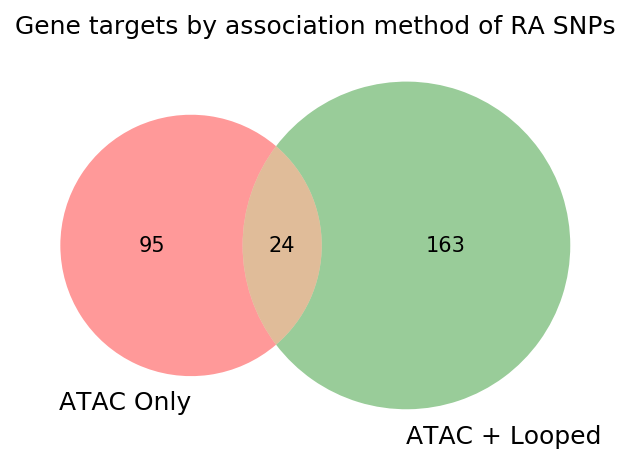

In [102]:
f, ax = plt.subplots(1,1,figsize=(5,5), dpi=150)
venn2((atac_only, looped), set_labels=("ATAC Only", "ATAC + Looped"))
plt.title("Gene targets by association method of RA SNPs")
plt.show()

/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


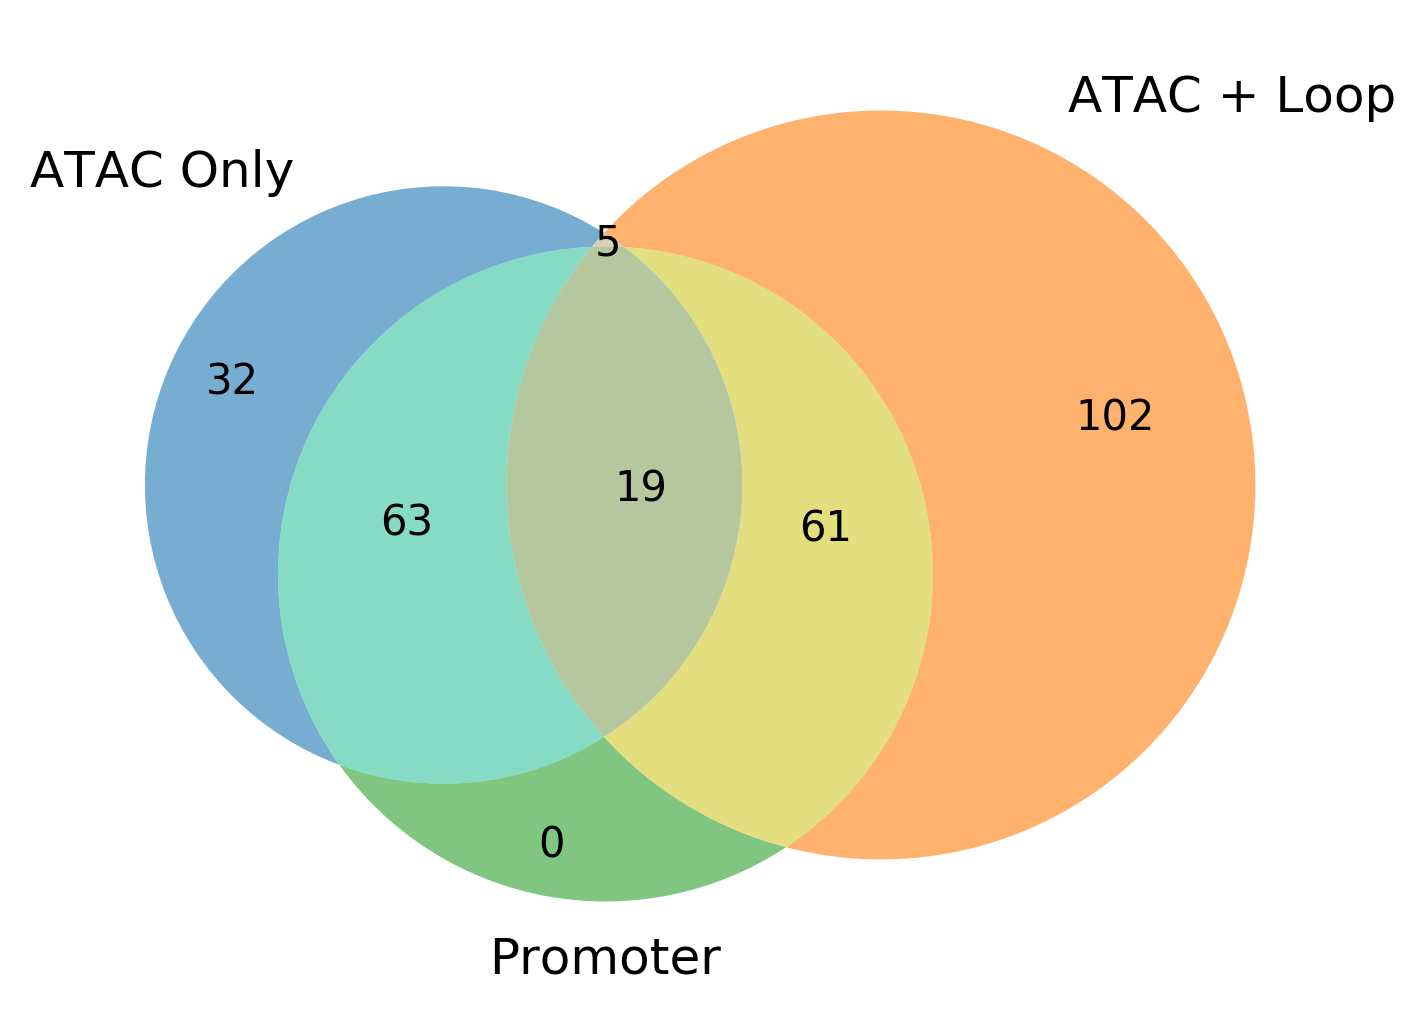

In [103]:
f, ax = plt.subplots(1,1,figsize=(5,5), dpi=300)
venn3((atac_only, #Remove all the weird genes (pseudogenes or other)
       looped,
      promoter),
     set_labels=("ATAC Only", "ATAC + Loop", "Promoter"), 
      set_colors=sns.palettes.color_palette()[:3], alpha=0.6, ax=ax)
# ax.set_title("Genes Targeted by >= 1 SNP", pad=20, size=20)
f.tight_layout()

Ok , so incorporating looping identifies novel target genes. Which are they? Do we have some examples of obvious importance?

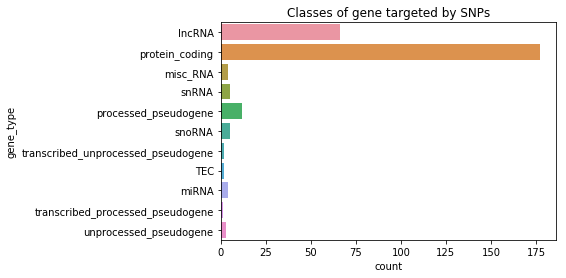

In [77]:
sns.countplot(data=all_interactions[~all_interactions.name_snp.isna()].drop_duplicates(["name_gene"]), y="gene_type")
plt.title("Classes of gene targeted by SNPs")
plt.show()

# Load RPKM data

In [78]:
%cd /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data

/gpfs/fs1/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data


In [79]:
!pwd

/gpfs/fs1/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data


In [80]:
th_rpkm = pd.read_table("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/rna-seq/190311_human_th_rnaseq/rpkm_bygroup.tab")
th_rpkm.drop(columns=['Geneid', 'Length'], inplace=True)
th_rpkm = th_rpkm.dropna(subset=["gene_symbol"])

/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


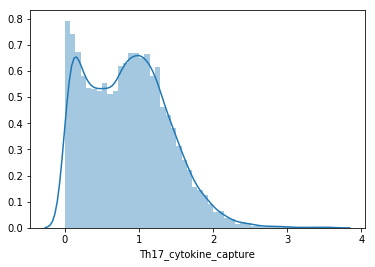

In [81]:
sns.distplot(np.log10(th_rpkm.Th17_cytokine_capture+1))

In [83]:
all_interactions_rpkm = pd.merge(all_interactions, th_rpkm, on='gene_symbol', how='left')
all_interactions_rpkm.to_csv("atac_snp_loop_ps/all_interactions_rpkm.tab", sep="\t", index=False)
all_interactions_rpkm

,chrom_anc_at,start_anc_at,end_anc_at,chrom_atac,start_atac,end_atac,name_atac,name_anc,anc_pos_at,chrom_anc_ge,...,gene_symbol,gene_type,atac_promoter,is_lead_snp,is_looped,description,Th1_cytokine_capture,Th1_standard,Th17_cytokine_capture,Th17_standard
0,chr1,980000.0,990000.0,chr1,981176.0,981979.0,chr1.981177.981979,loop.0,left,chr1,...,AL645608.8,lncRNA,False,False,True,NaN,NaN,NaN,NaN,NaN
1,chr1,980000.0,990000.0,chr1,981176.0,981979.0,chr1.981177.981979,loop.0,left,chr1,...,AL390719.1,transcribed_unprocessed_pseudogene,False,False,True,NaN,1.070383,3.702225,1.389806,2.604054
2,chr1,980000.0,990000.0,chr1,984028.0,984645.0,chr1.984029.984645,loop.0,left,chr1,...,AL645608.8,lncRNA,False,False,True,NaN,NaN,NaN,NaN,NaN
3,chr1,980000.0,990000.0,chr1,984028.0,984645.0,chr1.984029.984645,loop.0,left,chr1,...,AL390719.1,transcribed_unprocessed_pseudogene,False,False,True,NaN,1.070383,3.702225,1.389806,2.604054
4,chr1,1060000.0,1070000.0,chr1,1058908.0,1060229.0,chr1.1058909.1060229,loop.0,right,chr1,...,PERM1,protein_coding,True,False,True,NaN,NaN,NaN,NaN,NaN
5,chr1,1060000.0,1070000.0,chr1,1063617.0,1064845.0,chr1.1063618.1064845,loop.0,right,chr1,...,PERM1,protein_coding,True,False,True,NaN,NaN,NaN,NaN,NaN
6,chr1,1060000.0,1070000.0,chr1,1068561.0,1070150.0,chr1.1068562.1070150,loop.0,right,chr1,...,PERM1,protein_coding,False,False,True,NaN,NaN,NaN,NaN,NaN
7,chr1,1120000.0,1125000.0,chr1,1121668.0,1122974.0,chr1.1121669.1122974,loop.1,left,chr1,...,TNFRSF18,protein_coding,False,False,True,TNF receptor superfamily member 18 [Source:HGN...,36.415398,9.411021,43.451214,9.871080
8,chr1,1205000.0,1210000.0,chr1,1207942.0,1209199.0,chr1.1207943.1209199,loop.1,right,chr1,...,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN
9,chr1,1120000.0,1125000.0,chr1,1121668.0,1122974.0,chr1.1121669.1122974,loop.2,left,chr1,...,B3GALT6,protein_coding,False,False,True,"beta-1,3-galactosyltransferase 6 [Source:HGNC ...",9.910156,7.159846,7.532108,6.526830


In [84]:
all_interactions_rpkm.dropna(subset=['name_snp']).to_csv("atac_snp_loop_ps/all_interactions_with_snp.tab", sep="\t", index=False)

## Pivoting by genes or SNPs

In [85]:
filtered_linkage = pd.read_table("atac_snp_loop_ps/all_interactions_with_snp.tab")

In [86]:
filtered_linkage.shape

(810, 34)

In [104]:
snp_info = pd.read_csv("ld_expansion_psoriasis/ld_snps_info_new.tab", 
                       sep="\t").drop(columns=['synonyms', 'chrom', 'start', 'end'])

In [105]:
snp_info_cols = snp_info.columns.tolist()

In [106]:
snp_info_cols

['d_prime',
 'query',
 'r2',
 'result',
 'MAF',
 'allele_string',
 'consequence',
 'minor_allele',
 'snp_id']

In [107]:
snp_info_cols[0] = "lead_snp"
snp_info.columns = snp_info_cols

In [108]:
snp_info.drop_duplicates(subset=['lead_snp', 'result'])

,lead_snp,query,r2,result,MAF,allele_string,consequence,minor_allele,snp_id
0,0.994452,rs1975974,0.972809,rs4889703,0.20010,T/C,intron_variant,C,rs4889703
1,1.000000,rs1975974,0.983694,rs11870387,0.18350,G/C/T,intron_variant,C,rs11870387
2,0.983164,rs1975974,0.930435,rs41361749,0.20570,G/A,intergenic_variant,A,rs41361749
3,0.936372,rs1975974,0.804445,rs2342183,0.18810,G/T,intergenic_variant,T,rs2342183
4,1.000000,rs1975974,0.983694,rs1985718,0.18350,C/G/T,non_coding_transcript_exon_variant,T,rs1985718
5,1.000000,rs1975974,0.983694,rs112242970,0.21430,A/G,intron_variant,G,rs112242970
6,1.000000,rs1975974,0.978349,rs67946006,0.20250,T/A/C,intron_variant,C,rs67946006
7,0.988944,rs1975974,0.972651,rs56961409,0.20590,AAAAAAAAAA/AAAAAAAAA/AAAAAAAAAAA/AAAAAAAAAAAA/...,intron_variant,AA,rs56961409
8,1.000000,rs1975974,0.978349,rs7210944,0.21510,C/A/T,intron_variant,T,rs7210944
9,1.000000,rs1975974,0.978349,rs67473406,0.20110,G/A,intron_variant,A,rs67473406


In [110]:
filter_w_info = filtered_linkage.merge(snp_info, 
                                       left_on="name_snp", 
                                       right_on="result").drop(columns=['result', 'snp_id', 'score_gene', 'score'])

In [111]:
filter_w_info.to_csv("atac_snp_loop_ps/all_interactions_with_snp_info.tab", sep="\t", index=None)

In [112]:
# Get sorted list of genes with largest number of SNPs, removing duplicate gene-snp records
sorted_gene_by_n_snp = filtered_linkage.drop_duplicates(['name_gene', 'name_snp']).groupby('name_gene').size().sort_values(ascending=False)

In [113]:
filtered_linkage['th1_max_rpkm'] = filtered_linkage.loc[:,['Th1_cytokine_capture', 'Th1_standard']].max(axis=1)
filtered_linkage['th17_max_rpkm'] = filtered_linkage.loc[:,['Th17_cytokine_capture', 'Th17_standard']].max(axis=1)

In [114]:
# Produce a pivot table sorted by number of SNPs per gene
linkage_pivot_genes = filtered_linkage.pivot_table(index=['name_gene'], aggfunc={'name_snp' : lambda x: ';'.join(x),
                                                                                         'gene_symbol' : lambda x: np.unique(x),
                                                                                       'th1_max_rpkm' : max,
                                                                                       'th17_max_rpkm' : max})
linkage_pivot_genes = linkage_pivot_genes.iloc[linkage_pivot_genes.index.get_level_values(level=0).reindex(sorted_gene_by_n_snp.index)[1]]

In [115]:
linkage_pivot_genes['n_snps'] = linkage_pivot_genes['name_snp'].str.split(';').apply(lambda x: len(np.unique(x)))

In [116]:
linkage_pivot_genes.head()

,gene_symbol,name_snp,th17_max_rpkm,th1_max_rpkm,n_snps
name_gene,,,,,
ENSG00000247121.7,AC009126.1,rs2548224;rs3842058;rs148133629;rs2549785;rs25...,0.770487,0.733954,19
ENSG00000164308.17,ERAP2,rs2548224;rs3842058;rs148133629;rs2549785;rs25...,24.106701,33.153842,19
ENSG00000234745.11,HLA-B,rs561768797;rs561768797;rs3132510;rs1050414;rs...,728.203561,850.821528,11
ENSG00000162594.16,IL23R,rs963427;rs10889661;rs11465754;rs11465753;rs96...,9.173165,3.896839,9
ENSG00000288587.1,AL645933.5,rs28530646;rs140991764;rs3093958;rs59440261;rs...,NaN,NaN,8


In [117]:
sorted_gene_by_n_snp

name_gene
ENSG00000247121.7     19
ENSG00000164308.17    19
ENSG00000234745.11    11
ENSG00000162594.16     9
ENSG00000288587.1      8
ENSG00000184640.18     8
ENSG00000132481.7      8
ENSG00000264060.1      8
ENSG00000203963.11     8
ENSG00000266998.1      8
ENSG00000267016.1      8
ENSG00000267263.1      8
ENSG00000267801.1      8
ENSG00000113441.16     8
ENSG00000287257.1      8
ENSG00000171634.18     8
ENSG00000184588.18     7
ENSG00000206344.7      7
ENSG00000159128.14     7
ENSG00000271581.1      6
ENSG00000185651.14     6
ENSG00000277402.1      6
ENSG00000272501.1      6
ENSG00000101751.10     6
ENSG00000249738.10     5
ENSG00000154822.18     5
ENSG00000158195.11     5
ENSG00000113302.5      5
ENSG00000108175.17     5
ENSG00000204525.16     5
                      ..
ENSG00000206767.1      1
ENSG00000207118.1      1
ENSG00000135469.13     1
ENSG00000155849.15     1
ENSG00000135482.7      1
ENSG00000244641.2      1
ENSG00000135845.10     1
ENSG00000239628.1      1
ENSG00000238211

In [118]:
linkage_pivot_genes.to_excel("atac_snp_loop_ps/linkage_pivot_genes.xlsx")

In [119]:
sorted_snp_by_n_gene = filtered_linkage.drop_duplicates(['name_gene', 'name_snp']).groupby('name_snp').size().sort_values(ascending=False)
linkage_pivot_snps = filtered_linkage.pivot_table(index=['name_snp', 'name_gene'], aggfunc={'gene_symbol' : lambda x: np.unique(x),
                                                                                       'th1_max_rpkm' : max,
                                                                                       'th17_max_rpkm' : max,
                                                                                           'is_looped' : np.mean})
linkage_pivot_snps = linkage_pivot_snps.iloc[linkage_pivot_snps.index.get_level_values(level=0).reindex(sorted_snp_by_n_gene.index)[1]]

In [120]:
linkage_pivot_snps.to_excel('atac_snp_loop_ps/linkage_pivot_snps.xlsx')

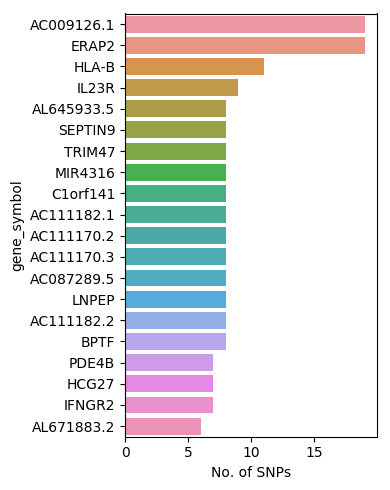

In [121]:
f, ax = plt.subplots(1,1,figsize=(4,5), dpi=100)
sns.barplot(data=linkage_pivot_genes[:20], y='gene_symbol', x="n_snps", ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("No. of SNPs")
f.tight_layout()

In [122]:
filtered_nodup = filtered_linkage[['name_gene', 'name_snp', 'is_looped', 'is_lead_snp', 'gene_symbol']].drop_duplicates()

In [123]:
linkage_pivot_genes.head(20)

,gene_symbol,name_snp,th17_max_rpkm,th1_max_rpkm,n_snps
name_gene,,,,,
ENSG00000247121.7,AC009126.1,rs2548224;rs3842058;rs148133629;rs2549785;rs25...,0.770487,0.733954,19
ENSG00000164308.17,ERAP2,rs2548224;rs3842058;rs148133629;rs2549785;rs25...,24.106701,33.153842,19
ENSG00000234745.11,HLA-B,rs561768797;rs561768797;rs3132510;rs1050414;rs...,728.203561,850.821528,11
ENSG00000162594.16,IL23R,rs963427;rs10889661;rs11465754;rs11465753;rs96...,9.173165,3.896839,9
ENSG00000288587.1,AL645933.5,rs28530646;rs140991764;rs3093958;rs59440261;rs...,NaN,NaN,8
ENSG00000184640.18,SEPTIN9,rs3833085;rs3903010;rs116044941;rs9908862;rs46...,NaN,NaN,8
ENSG00000132481.7,TRIM47,rs3833085;rs3903010;rs116044941;rs9908862;rs46...,10.546747,4.451467,8
ENSG00000264060.1,MIR4316,rs3833085;rs3903010;rs116044941;rs9908862;rs46...,NaN,NaN,8
ENSG00000203963.11,C1orf141,rs963427;rs10889661;rs11465754;rs11465753;rs96...,NaN,NaN,8


In [124]:
most_total_snps = linkage_pivot_genes.iloc[:20, 1].tolist()